In [1]:
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import mpl_toolkits.axisartist.floating_axes as floating_axes
import mpl_toolkits.axisartist.angle_helper as angle_helper
from mpl_toolkits.axisartist.grid_finder import MaxNLocator
from matplotlib.transforms import Affine2D

from astropy import constants as const
from astropy.table import Table

## Data files

In [3]:
#galaxy_filename = '/Users/kellydouglass/Documents/Drexel/Research/Data/kias1033_5_P-MJD-F_MPAJHU_ZdustOS_stellarMass_BPT_SFR_NSA_vflag.txt'
galaxy_filename = '/global/homes/d/dveyrat/VAST1/example_scripts/BGS_c000_ph000.dat'

#void_filename = '/Users/kellydouglass/Documents/Research/Voids/VoidFinder/void_catalogs/SDSS/python_implementation/vollim_dr7_cbp_102709_comoving_maximal.txt'
#void_filename = '/Users/kellydouglass/Documents/Research/Voids/VoidFinder/void_catalogs/SDSS/python_implementation/kias1033_5_MPAJHU_ZdustOS_main_comoving_maximal.txt'

## Import data

In [4]:
# Galaxy catalog
galaxies = Table.read(galaxy_filename, format='ascii.commented_header', 
                      include_names=['ra', 'dec', 'redshift'])#, 'Rgal', 'vflag'])

# Void catalog (detected voids, output of voidfinder)
#voids = Table.read(void_filename, format='ascii.commented_header')

## Convert redshift to distance
Going to plot $cz$ in km/s

Note: Multiply distances in Mpc/h by 100 ($= H_0 = 100h$) to convert to km/s.

In [13]:
c = const.c.to('km/s').value

galaxies['cz'] = c*galaxies['redshift']

print(min(galaxies['cz']), max(galaxies['cz']))
#print(min(galaxies['Rgal']), max(galaxies['Rgal']))
#print(min(voids['r']*100), max(voids['r']*100))
#print(min(voids['radius']*100), max(voids['radius']*100))

23.930881785118093 239774.44825830671


## Function to set up axes

Following matplotlib demo : https://matplotlib.org/examples/axes_grid/demo_floating_axes.html

In [8]:
def setup_axes3(fig, rect, ra0, ra1, cz0, cz1):
    
    # rotate a bit for better orientation
    tr_rotate = Affine2D().translate(-90, 0)
    
    # scale degree to radians
    tr_scale = Affine2D().scale(np.pi/180, 1)

    tr = tr_rotate + tr_scale + mpl.projections.PolarAxes.PolarTransform()
    
    grid_locator1 = angle_helper.LocatorHMS(4)
    tick_formatter1 = angle_helper.FormatterHMS()
    
    grid_locator2 = MaxNLocator(3)
    
    grid_helper = floating_axes.GridHelperCurveLinear(tr, extremes=(ra0, ra1, cz0, cz1),
                                                      grid_locator1=grid_locator1,
                                                      grid_locator2=grid_locator2,
                                                      tick_formatter1=tick_formatter1,
                                                      tick_formatter2=None)

    ax1 = floating_axes.FloatingSubplot(fig, rect, grid_helper=grid_helper)
    fig.add_subplot(ax1)
    
    # adjust axis
    ax1.axis['left'].set_axis_direction('bottom')
    
    ax1.axis['right'].set_axis_direction('top')
    
    ax1.axis['bottom'].set_visible(False)
    
    ax1.axis['top'].set_axis_direction("bottom")
    ax1.axis['top'].toggle(ticklabels=True, label=True)
    ax1.axis['top'].major_ticklabels.set_axis_direction("top")
    ax1.axis['top'].label.set_axis_direction("top")
    
    #ax1.axis['left'].major_ticklabels.set_axis_direction('right')
    ax1.axis["left"].label.set_text("cz [km/s]")
    
    aux_ax = ax1.get_aux_axes(tr)

    aux_ax.patch = ax1.patch  
    ax1.patch.zorder = 0.9  

    return ax1, aux_ax

## Wedge plot

In [15]:
# 'd' is declination and 's' is the thickness of the declination slice
# Vary 'd' and 's' to get difference slices.
d,s = 26,2

# slice center, can use this for analysis since the slice thickness is very small.
slice_= d + 0.5*s


################################################################################
# Remove galaxies outside declination range
#-------------------------------------------------------------------------------
galaxies_dec_cut = np.logical_and(galaxies['dec'] > d, 
                                  galaxies['dec'] <= d+s)
galaxies_dec_slice = galaxies[galaxies_dec_cut]
################################################################################


################################################################################
# Remove galaxies outside distance range
#-------------------------------------------------------------------------------
cz_min, cz_max = 0, 67740.28

galaxies_dist_boolean = np.logical_and(galaxies_dec_slice['cz'] > cz_min, 
                                       galaxies_dec_slice['cz'] <= cz_max)
galaxies_sample = galaxies_dec_slice[galaxies_dist_boolean]

print(len(galaxies_sample))
print(min(galaxies_sample['ra']), max(galaxies_sample['ra']))
################################################################################

'''
################################################################################
# Voids that intersect the slice
#-------------------------------------------------------------------------------
dec_intersect_cut = np.sin(np.abs(slice_ - voids['dec'])*np.pi/180)*voids['r'] <= voids['radius']
void_sample = voids[dec_intersect_cut]

# Radius of void at intersection
void_sample['radius_intersect'] = np.sqrt(void_sample['radius']**2 
                                          - (np.sin(np.abs(slice_ - void_sample['dec'])*np.pi/180)*void_sample['r'])**2)
################################################################################


################################################################################
# Transform hole centers from (ra, r) to (x, y)
#-------------------------------------------------------------------------------
void_sample['x_polar'] = 100*void_sample['r']*np.cos(void_sample['ra']*np.pi/180 - 0.5*np.pi)
void_sample['y_polar'] = 100*void_sample['r']*np.sin(void_sample['ra']*np.pi/180 - 0.5*np.pi)
################################################################################
''';

156409
39.18217468261719 328.4007263183594


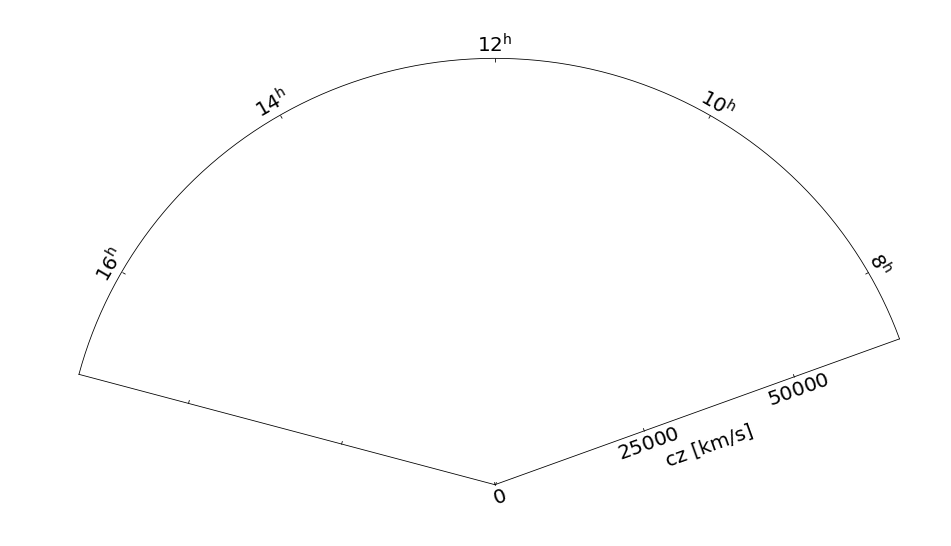

In [16]:
fig = plt.figure(figsize=(15,8))

# Range of RA to use in plot
ra_min, ra_max = 110, 255

ax, aux_ax = setup_axes3(fig, 111, ra_min, ra_max, cz_min, cz_max)


# Galaxies
aux_ax.plot(galaxies_sample['ra'], 
            galaxies_sample['cz'], 
            '.', ms=3)
# aux_ax.plot(galaxies_sample['ra'][galaxies_sample['vflag'] == 0], 
#             galaxies_sample['cz'][galaxies_sample['vflag'] == 0], 
#             '.', c='0.5', ms=3, zorder=1, label='Wall')
#             #'.', c='0.5', zorder=1, label='Wall')
# aux_ax.plot(galaxies_sample['ra'][galaxies_sample['vflag'] == 1], 
#             galaxies_sample['cz'][galaxies_sample['vflag'] == 1], 
#             '.', c=(1,135/255,123/255), ms=3, zorder=2, label='Void')
#             #'.', c=(1,135/255,123/255), zorder=2, label='Void')
'''
# Voids
holes = [plt.Circle((x,y), radius=r*100, transform=aux_ax.transData._b, fill=False, ec='b') 
         for x,y,r in zip(void_sample['x_polar'], void_sample['y_polar'], void_sample['radius_intersect'])]
for hole in holes:
    aux_ax.add_artist(hole)
'''
'''
aux_ax.scatter(void_sample['ra'], void_sample['r']*100, edgecolors='b', 
               s=void_sample['radius_intersect']*100, facecolors='none', 
               linewidth=1.5, zorder=3)
'''
# ax.legend(bbox_to_anchor=(1.1, 1.05))

mpl.rc('font', size=20)

plt.tight_layout();

#plt.savefig('DR7_wedge.eps', format='eps', dpi=300)

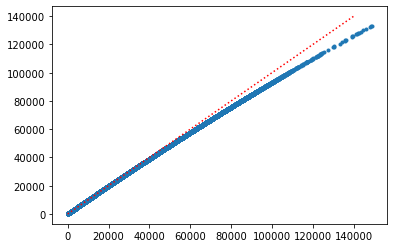

In [9]:
plt.figure()
plt.plot(galaxies['cz'], galaxies['Rgal']*100, '.')
plt.plot([0,140000],[0,140000], 'r:');

In [21]:
void_sample[:10]

x,y,z,radius,flag,r,ra,dec,radius_intersect
float64,float64,float64,float64,int64,float64,float64,float64,float64
-209.39394855584018,-128.1275703497601,145.3854186002218,21.910827777217815,0,285.3058357571753,211.46234691177074,30.635687611937033,12.35998220797202
-221.44890152228987,55.71128126251251,134.4959164833291,21.283148588425963,3,265.0141777264572,165.87878885118994,30.49775544683522,13.840388568191093
-148.03636735383023,73.95501299266013,106.20203891118753,20.878937107410103,6,196.6290494178215,153.45451175288395,32.69137767555475,7.462678329722913
-142.10777806151484,-35.07207036150132,61.15507101378606,18.52313336265639,24,158.6335822445048,193.86350343265883,22.675498778453406,14.142916871737624
-105.17092937474861,-13.589541886441626,41.37291298950357,17.7862731688569,32,113.83021551182597,187.36261382493248,21.31293796106023,13.751831074224974
-183.65096499289976,73.40165195304895,81.11287653734588,17.672752473158447,33,213.76336962263332,158.2143887722821,22.29972456825944,2.3450487615952422
-215.9937326082096,141.7075891315585,115.03158678386028,16.456572314531122,63,282.78366165943555,146.73221357929077,24.00290756866329,7.225652141825705
-252.48195718117285,4.71975054918518,119.18860301238118,16.152712826569832,75,279.24064502741203,178.9290708240384,25.2666237985708,13.768255737204646
-236.86875152835475,-112.16947618118719,123.95161492761339,16.009803629842867,77,289.91860871721696,205.3399502212222,25.31150247604107,13.5402170388489
